<a href="https://colab.research.google.com/github/renaops/GeneralNNClassificatorPytorch/blob/main/general_pipeline_for_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $Universidade$ $Federal$ $de$ $Viçosa$ $(UFV)$ - Campus Viçosa

### Trabalho Final

**Alunos:** Erick Lima Figueiredo, Guilherme Oliveira Fonseca e Renan Lopes |
**MA:** 98898, 98889 e 97370

**Professor:** Lucas Nascimento Ferreira

**Disciplina:** Aprendizado em Redes Neurais Profundas (INF 721)


## Dataset: A neural network for classifying image data of natural scenes from around the world

**Source Dataset:** https://www.kaggle.com/datasets/puneet6060/intel-image-classification/data, https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification/data

**Dataset Google Drive** https://drive.google.com/drive/folders/1hm0LIi2OD2-CirIbJa3E_4Rg9zyPuJoL?usp=sharing

**Code Repo:** https://github.com/renaops/IntelImageClassificationNN

**Google Colab:** https://colab.research.google.com/drive/1OSpWIk_VxjrZIXt47-DgpX5XCvpKjVMk


### 1. Importing Libraries

In [56]:
import os
import time
import math
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as transforms_v2

import seaborn as sns
import matplotlib.pyplot as plt

drive = None
try:
    from google.colab import drive
except Exception as e:
    print('Você está fora do google colab!')

%matplotlib inline


In [57]:
USING_CUDA = torch.cuda.is_available()

f'Pytorch {"" if USING_CUDA else "não "}está usando o CUDA!'

'Pytorch não está usando o CUDA!'

In [58]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


#### 1.1 Plots

In [59]:
def plot_learning_curve(train_losses, val_losses, num_epochs, size=(8, 5)):
    """
    Plot the learning curve based on training and validation losses over epochs.

    Args:
    - train_losses (list): List of training losses for each epoch.
    - val_losses (list): List of validation losses for each epoch.
    - num_epochs (int): Total number of training epochs.
    - size (tuple, optional): Figure size (width, height). Default is (8, 5).

    Returns:
    None

    Example:
    >>> train_loss = [0.1, 0.08, 0.05, 0.04]
    >>> val_loss = [0.2, 0.15, 0.1, 0.08]
    >>> plot_learning_curve(train_loss, val_loss, num_epochs=4)
    """
    plt.figure(figsize=size)
    plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='#ff5a7d', label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, marker='x', linestyle='-', color='#ff9e00', label='Validation Loss')

    plt.title('Learning Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Average Loss')
    plt.legend()
    plt.show()


def plot_confusion_matrix(conf_matrix, class_labels, title):
    """
    Plot a confusion matrix.

    Args:
    - conf_matrix (array-like): Confusion matrix.
    - class_labels (list): List of class labels.
    - title (str): Title for the plot.

    Returns:
    None

    Example:
    >>> confusion_matrix = [[20, 5], [2, 30]]
    >>> class_labels = ['Class A', 'Class B']
    >>> plot_confusion_matrix(confusion_matrix, class_labels, title='Model Performance')
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", yticklabels=class_labels, xticklabels=class_labels)
    plt.title(f'Confusion Matrix {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def plot_class_distribution(dataframe, column_name, title):
    """
    Plot the distribution of classes in a specified column of a DataFrame.

    Args:
    - dataframe (pandas.DataFrame): The DataFrame containing the data.
    - column_name (str): The name of the column representing the classes.
    - title (str): The title for the plot.

    Returns:
    None

    Example:
    >>> import pandas as pd
    >>> import seaborn as sns
    >>> data = {'Class': ['A', 'B', 'A', 'C', 'B', 'A', 'C', 'C']}
    >>> df = pd.DataFrame(data)
    >>> plot_class_distribution(df, 'Class', title='Class Distribution')
    """
    sns.countplot(x=column_name, data=dataframe, order=sorted(dataframe[column_name].unique()))
    plt.title(f'{title} Distribution')
    plt.xticks(rotation=45)
    plt.show()

### 2. Dataset Loading

In [60]:
def get_content_from_partition(partition, data_path):
    """
    Retrieve a list of dictionaries containing information about images in a specified partition.

    Args:
    - partition (str): The partition name, such as 'train', 'test', or 'validation'.
    - data_path (str): The base path where the data is stored.

    Returns:
    list: A list of dictionaries, where each dictionary represents an image with the following keys:
        - 'class': The class or label of the image.
        - 'img': The full path to the image file.

    Example:
    >>> data = get_content_from_partition('train', '/path/to/data')
    >>> print(data)
    [{'class': 'cat', 'img': '/path/to/data/train/cat/cat_image.jpg'},
        {'class': 'dog', 'img': '/path/to/data/train/dog/dog_image.png'},
        ...]
    """
    partition_data = []
    for clazz in os.listdir(os.path.join(data_path, partition)):
        for img in os.listdir(os.path.join(data_path, partition, clazz)):
            if img.endswith('.jpg') or img.endswith('.png'):
                partition_data.append({'class': clazz, 'img': os.path.join(data_path, partition, clazz, img)})
    print(partition_data)
    return partition_data

In [61]:
if drive:
    drive.mount('/content/drive', force_remount=True)
    data_path = '/content/drive/Shareddrives/Deep Learning'
else:
    data_path = './'

data_path += '/food-101'

Mounted at /content/drive


In [62]:
train_df = pd.DataFrame(get_content_from_partition('train', data_path))
val_df = pd.DataFrame(get_content_from_partition('validation', data_path))
test_df = pd.DataFrame(get_content_from_partition('test', data_path))

[{'class': 'donuts', 'img': '/content/drive/Shareddrives/Deep Learning/food-101/train/donuts/2965797.jpg'}, {'class': 'donuts', 'img': '/content/drive/Shareddrives/Deep Learning/food-101/train/donuts/2832318.jpg'}, {'class': 'donuts', 'img': '/content/drive/Shareddrives/Deep Learning/food-101/train/donuts/1912405.jpg'}, {'class': 'donuts', 'img': '/content/drive/Shareddrives/Deep Learning/food-101/train/donuts/3650350.jpg'}, {'class': 'donuts', 'img': '/content/drive/Shareddrives/Deep Learning/food-101/train/donuts/598288.jpg'}, {'class': 'donuts', 'img': '/content/drive/Shareddrives/Deep Learning/food-101/train/donuts/700534.jpg'}, {'class': 'donuts', 'img': '/content/drive/Shareddrives/Deep Learning/food-101/train/donuts/449743.jpg'}, {'class': 'donuts', 'img': '/content/drive/Shareddrives/Deep Learning/food-101/train/donuts/3864694.jpg'}, {'class': 'donuts', 'img': '/content/drive/Shareddrives/Deep Learning/food-101/train/donuts/448512.jpg'}, {'class': 'donuts', 'img': '/content/dri

In [63]:
print(f'> Train size: {len(train_df)}\n> Val size: {len(val_df)}\n> Test size: {len(test_df)}')

> Train size: 7000
> Val size: 1500
> Test size: 1500


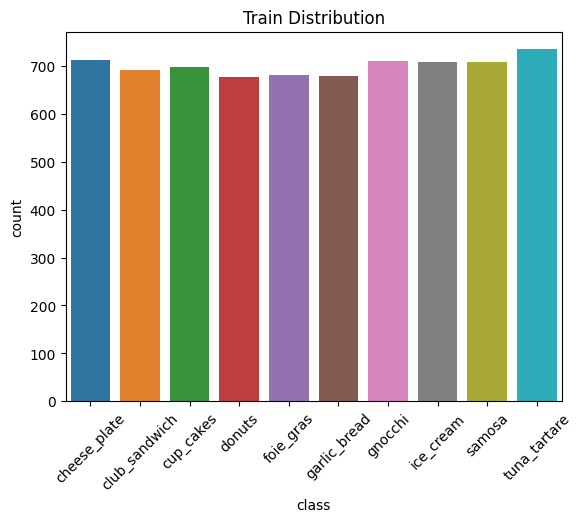

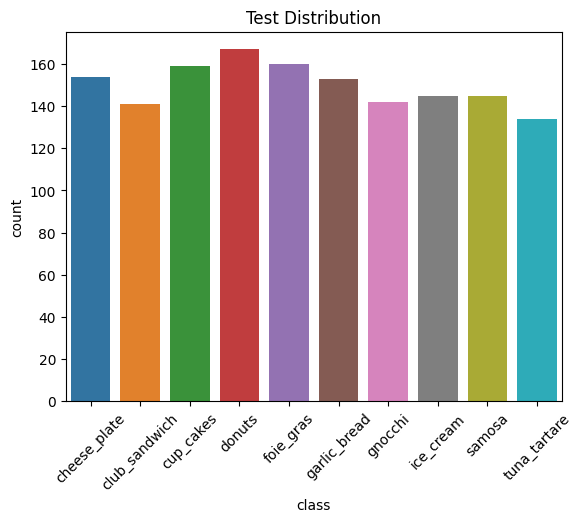

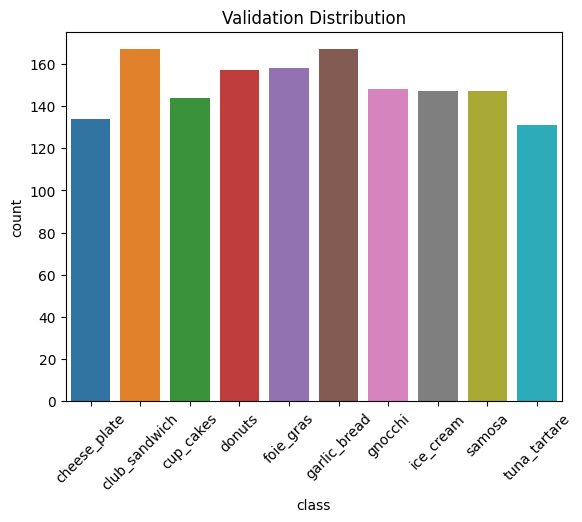

In [64]:
plot_class_distribution(train_df, 'class', 'Train')
plot_class_distribution(test_df, 'class', 'Test')
plot_class_distribution(val_df, 'class', 'Validation')

### 3. Preprocessing and Augmentation

In [65]:
class EnvironmentsDataset(Dataset):
    """
    A custom PyTorch dataset for working with image data in environments.

    Args:
    - df (pandas.DataFrame): The DataFrame containing image file paths and class labels.
    - transform (callable, optional): A function/transform that takes in an image and returns a transformed version.
    - target_name (str, optional): The name of the column in 'df' containing class labels. Default is 'class'.
    - shuffle (bool, optional): Whether to shuffle the dataset. Default is True.

    Attributes:
    - class_names (list): List of unique class names present in the dataset.
    - data (pandas.DataFrame): The DataFrame representing the dataset.

    Methods:
    - __len__: Returns the number of samples in the dataset.
    - __getitem__: Returns the image and label for a given index.

    Example:
    >>> dataset = EnvironmentsDataset(df, transform=transforms.ToTensor(), target_name='label', shuffle=True)
    >>> print(dataset.class_names)
    ['class_A', 'class_B', 'class_C']
    >>> print(len(dataset))
    1000
    >>> img, label = dataset[0]
    >>> print(img.shape, label)
    (3, 224, 224), 0
    """

    def __init__(self, df, transform=None, target_name='class', shuffle=True):
        self._data = self._shuffle(df) if shuffle else df
        self._transform = transform
        self._class_names = list(self.data[target_name].unique())

    @property
    def class_names(self):
        """List of unique class names present in the dataset."""
        return self._class_names

    @property
    def data(self):
        """The DataFrame representing the dataset."""
        return self._data

    def __len__(self):
        """Returns the number of samples in the dataset."""
        return len(self.data)

    def __getitem__(self, idx):
        """Returns the image and label for a given index."""
        img = read_image(self._data.loc[idx, 'img'])[:3, :, :]

        label = self._class_names.index(self._data.loc[idx, 'class'])

        if self._transform:
            img = self._transform(img)

        return img, label

    def _shuffle(self, df):
        """Shuffles the DataFrame."""
        return df.sample(frac=1).reset_index(drop=True)


In [66]:
def custom_transforms():
    """
    Returns a composed set of image transformations using torchvision.transforms.

    The transformations include:
    - Convert the image to dtype torch.float32 with scaling.
    - Resize the image to (224, 224) with antialiasing.
    - Apply random rotation to the image within the range of -45 to 45 degrees.
    - Randomly flip the image horizontally with a probability of 0.5.

    Returns:
    torchvision.transforms.Compose: Composed set of image transformations.

    Example:
    >>> transform = my_transforms()
    >>> img_transformed = transform(img)
    """
    return transforms_v2.Compose([
        transforms_v2.ToDtype(torch.float32, scale=True),
        transforms_v2.Resize(size=(224, 224), antialias=True),
        transforms_v2.RandomRotation(degrees=(-45, 45)),
        transforms_v2.RandomHorizontalFlip(p=0.5),
    ])


In [67]:
train_dataset = EnvironmentsDataset(train_df, transform=custom_transforms())
val_dataset = EnvironmentsDataset(val_df, transform=custom_transforms())
test_dataset = EnvironmentsDataset(test_df, transform=custom_transforms())

This is a ice_cream



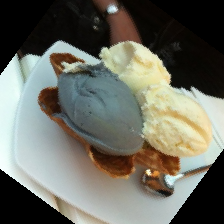

In [68]:
print('This is a ' + train_dataset.class_names[train_dataset[0][1]], end='\n\n')
transforms.ToPILImage()(train_dataset[0][0])

# 4. Model Architecture and Training

In [69]:
BATCH_SIZE = 64
NUM_EPOCHS = 5
NUM_CLASSES = len(train_dataset.class_names)
MODEL_SAVE_PATH = './'
MODEL_NAME = 'satellite_vision'

In [70]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [71]:
class EnvClassificationNet(nn.Module):
    """
    Convolutional Neural Network (CNN) for environmental classification.

    Args:
    - num_classes (int): Number of classes for classification.

    Attributes:
    - pool (nn.MaxPool2d): Max pooling layer.
    - conv1, conv2, conv3, conv4, conv5, conv6 (nn.Conv2d): Convolutional layers.
    - batch1, batch2, batch3, batch4, batch5, batch6, batch7 (nn.BatchNorm2d or nn.BatchNorm1d): Batch normalization layers.
    - dropout1, dropout2, dropout3, dropout4 (nn.Dropout): Dropout layers.
    - fc1 (nn.Linear): Fully connected layer.
    - out (nn.Linear): Output layer.

    Methods:
    - forward: Defines the forward pass of the network.
    """

    def __init__(self, num_classes):
        super(EnvClassificationNet, self).__init__()

        self.pool = nn.MaxPool2d((2, 2))

        self.conv1 = nn.Conv2d(3, 32, 3)
        self.batch1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.batch2 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(0.3)

        self.conv3 = nn.Conv2d(32, 64, 3)
        self.batch3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 3)
        self.batch4 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(0.5)

        self.conv5 = nn.Conv2d(64, 128, 3)
        self.batch5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, 3)
        self.batch6 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout(0.5)

        self.fc1 = nn.Linear(128 * 24 * 24, 128)
        self.batch7 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(0.5)
        self.out = nn.Linear(128, num_classes)

    def forward(self, x):
        """
        Defines the forward pass of the network.

        Args:
        - x (torch.Tensor): Input tensor.

        Returns:
        torch.Tensor: Output tensor.
        """
        x = F.relu(self.conv1(x))
        x = self.batch1(x)
        x = F.relu(self.conv2(x))
        x = self.batch2(x)
        x = self.pool(x)
        x = self.dropout1(x)

        x = F.relu(self.conv3(x))
        x = self.batch3(x)
        x = F.relu(self.conv4(x))
        x = self.batch4(x)
        x = self.pool(x)
        x = self.dropout2(x)

        x = F.relu(self.conv5(x))
        x = self.batch5(x)
        x = F.relu(self.conv6(x))
        x = self.batch6(x)
        x = self.pool(x)
        x = self.dropout3(x)

        x = x.view(-1, 128 * 24 * 24)

        x = F.relu(self.fc1(x))
        x = self.batch7(x)
        x = self.dropout4(x)
        x = self.out(x)

        return x

In [72]:
def calc_val_loss(model, dataloader, loss_function):
    """
    Calculate the average validation loss for a given model, dataloader, and loss function.

    Args:
    - model (torch.nn.Module): The neural network model.
    - dataloader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
    - loss_function (torch.nn.modules.loss._Loss): The loss function used for evaluation.

    Returns:
    float: The average validation loss.

    Example:
    >>> net = EnvClassificationNet(num_classes=10)
    >>> val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    >>> criterion = nn.CrossEntropyLoss()
    >>> val_loss = calc_val_loss(net, val_dataloader, criterion)
    >>> print(val_loss)
    0.1234
    """
    with torch.no_grad():
        total_loss = 0.0
        for batch in dataloader:
            imgs, labels = batch

            if USING_CUDA:
                imgs = imgs.to('cuda')
                labels = labels.to('cuda')

            outputs = model(imgs)
            batch_loss = loss_function(outputs, labels).item()
            total_loss += batch_loss

        average_loss = total_loss / len(dataloader)

    return average_loss

In [73]:
def format_time(seconds):
    if seconds < 60:
        return f'{seconds:.2f}s'
    else:
        m, s = divmod(seconds, 60)
        h, m = divmod(m, 60)

        return f'{int(m)}m{s:.2f}s' if h <= 0 else f'{h}h{int(m)}m{s:.2f}s'

In [74]:
model = EnvClassificationNet(NUM_CLASSES)

if USING_CUDA:
    model.cuda()

In [75]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [76]:
def optimize(model, train_loader, val_loader, loss_func, optimizer, num_epochs, output_path):
    """
    Train and optimize a neural network model.

    Args:
    - model (torch.nn.Module): The neural network model.
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
    - val_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
    - loss_func (torch.nn.modules.loss._Loss): The loss function used for training.
    - optimizer (torch.optim.Optimizer): The optimizer used for training.
    - num_epochs (int): Number of training epochs.
    - output_path (str): File path to save the trained model.

    Returns:
    tuple: Lists of training and validation losses over epochs.

    Example:
    >>> net = EnvClassificationNet(num_classes=10)
    >>> train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    >>> val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    >>> criterion = nn.CrossEntropyLoss()
    >>> optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    >>> train_losses, val_losses = optimize(net, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=10, output_path='model.pth')
    """
    train_losses = []
    val_losses = []

    for epoch in range(1, num_epochs + 1):
        start_time = time.time()
        total_time = 0
        total_loss = 0.0

        print(f'Epoch: {epoch}/{num_epochs}')
        for i, batch in enumerate(train_loader):
            optimizer.zero_grad()
            imgs, labels = batch

            if USING_CUDA:
                imgs = imgs.to('cuda')
                labels = labels.to('cuda')

            loss = loss_func(model(imgs), labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            iteration_time = time.time() - start_time
            total_time += iteration_time

            avg_iteration_time = total_time / (i + 1)
            remaining_iterations = len(train_loader) - (i + 1)
            remaining_time = remaining_iterations * avg_iteration_time

            completion_percentage = (i + 1) / len(train_loader) * 100
            formatted_completion_percentage = math.floor(completion_percentage / 3.333)

            print(f'\r{i+1}/{len(train_loader)} [{"="*(formatted_completion_percentage)}{"."*(30 - formatted_completion_percentage)}] - {format_time(iteration_time)}/step - Loss: {loss:.6f} - {"Total Time" if i+1 == len(train_loader) else "ETA"}: {format_time(total_time) if i+1 == len(train_loader) else format_time(remaining_time)}', end='', flush=True)

        train_losses.append(total_loss / len(train_loader))
        val_losses.append(calc_val_loss(model, val_loader, loss_func))
        print(f" || Train Loss:{train_losses[-1]:.6f} - Val Loss:{val_losses[-1]:.6f}")

    print('\nComplete! =)')
    torch.save(model.state_dict(), output_path)

    return train_losses, val_losses

In [ ]:
train_losses, val_losses = optimize(model, train_loader, val_loader, loss_func, optimizer, NUM_EPOCHS, os.path.join(MODEL_SAVE_PATH, MODEL_NAME + '.pth'))

Epoch: 1/5


### 5. Model Evaluation

In [ ]:
plot_learning_curve(train_losses, val_losses, NUM_EPOCHS)

In [ ]:
def evaluate_model_accuracy(model, dataloader, num_classes, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    wrong_preds = []

    with torch.no_grad():
        for imgs, labels in dataloader:
            if USING_CUDA:
                imgs = imgs.to('cuda')
                labels = labels.to('cuda')

            preds = torch.argmax(model(imgs).data, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Check for incorrect predictions
            wrong_mask = preds != labels
            wrong_indices = torch.nonzero(wrong_mask).squeeze().cpu().numpy()
            wrong_preds.extend(zip(wrong_indices, preds[wrong_mask].cpu().numpy(), labels[wrong_mask].cpu().numpy(), imgs[wrong_mask].cpu()))

    accuracy = (sum([1 for i, j in zip(all_preds, all_labels) if i == j]) / len(all_labels))
    confusion_mat = confusion_matrix(all_labels, all_preds, labels=range(num_classes))

    print(f'Accuracy: {accuracy * 100:.2f}%')
    print('Confusion Matrix:')
    print(confusion_mat)

    # Display images for incorrect predictions
    for idx, pred, label, img in wrong_preds:
        img = img.squeeze().permute(1, 2, 0).numpy()  # Assuming your images are in the shape (C, H, W)
        plt.imshow(img)
        plt.title(f'True: {class_names[label]}, Predicted: {class_names[pred]}')
        plt.show()

In [ ]:
# Adicionar aqui a opção de carregar o modelo para a memória

model.eval()

train_accuracy, conf_mtrx_train = evaluate_model_accuracy(model, train_loader, NUM_CLASSES, train_df['class'].unique())
test_accuracy, conf_mtrx_test = evaluate_model_accuracy(model, test_loader, NUM_CLASSES, train_df['class'].unique())

print("Train accuracy:", train_accuracy)
print("Test accuracy:", test_accuracy)

In [ ]:
print(conf_mtrx_train)

In [ ]:
plot_confusion_matrix(conf_mtrx_train, train_df['class'].unique(), "Train")

In [ ]:
plot_confusion_matrix(conf_mtrx_test, test_df['class'].unique(), "Test")